In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import integrate
import AnaUtils as au
import os,glob

In [2]:
def DRun(fname,nbase=50,winS=5,winF=5,cut=4,pmt=0,binw=0.5,ret=False):
    waves = au.ReadDDC10_BinWave(fname)
    waves[0],base = au.Subtract_Baseline(waves[0],nBase=nbase)
    #require baseline has no pulse. i.e. integral over baseline less than cut*rms
    bmask = np.absolute(integrate.simps(waves[0][:,pmt,:nbase]))<cut*integrate.simps(np.ones(nbase))*base[1][:,pmt]
    sumWave = waves[0][:,pmt,:].sum(axis=0)/float(waves[1]['numEvents'])
    PromptPeak = np.argmax(sumWave)
    plt.clf()
    plt.plot(sumWave,marker='x')
    plt.show()
    Qhist = au.winQHist(waves,ch=pmt,init=PromptPeak-winS,end=PromptPeak+winF,binW=binw,hrange=[-3,10],evMask=bmask[...,np.newaxis])
    if ret:
        Qhist['waves'] = waves[0][:,pmt]
        Qhist['evMask'] = bmask
        Qhist['baserms'] = base[0][:,pmt]
        return Qhist,waves[1]
    else:
        return Qhist['qHist']
    
def plotQ(qhist,sdir,xbase = 1.0):
    plt.clf()
    
    ax = plt.errorbar(qhist[1],qhist[0],marker='+',yerr=np.sqrt(qhist[2]))
    plt.gca().xaxis.set_major_locator(mpl.ticker.MultipleLocator(xbase))
    plt.xlabel('Q [pC]')
    plt.ylabel('dRate/dQ [Hz/pC]')
    plt.savefig(sdir+"/dQHist.png")
    plt.show()
    return plt.gcf()
from scipy.optimize import curve_fit


In [3]:
pmt = "KA0196"
wDir = '/global/cfs/cdirs/lz/users/heuerman/UmichData'
fWaves = [os.path.splitext(iF)[0] for iF in glob.glob('{}/DarkRun/{}*/*.bin'.format(wDir,pmt))]
fWaves.sort()
fWaves,

(['/global/cfs/cdirs/lz/users/heuerman/UmichData/DarkRun/KA0196_DR_1400V_2301121715/KA0196_DR_1400V_2301121715_0',
  '/global/cfs/cdirs/lz/users/heuerman/UmichData/DarkRun/KA0196_DR_1400V_2301121715/KA0196_DR_1400V_2301121715_1',
  '/global/cfs/cdirs/lz/users/heuerman/UmichData/DarkRun/KA0196_DR_1400V_2301121715/KA0196_DR_1400V_2301121715_2',
  '/global/cfs/cdirs/lz/users/heuerman/UmichData/DarkRun/KA0196_DR_1400V_2301121715/KA0196_DR_1400V_2301121715_3',
  '/global/cfs/cdirs/lz/users/heuerman/UmichData/DarkRun/KA0196_DR_1400V_2301121715/KA0196_DR_1400V_2301121715_4',
  '/global/cfs/cdirs/lz/users/heuerman/UmichData/DarkRun/KA0196_DR_1400V_2301121715/KA0196_DR_1400V_2301121715_5',
  '/global/cfs/cdirs/lz/users/heuerman/UmichData/DarkRun/KA0196_DR_1400V_2301121715/KA0196_DR_1400V_2301121715_6',
  '/global/cfs/cdirs/lz/users/heuerman/UmichData/DarkRun/KA0196_DR_1400V_2301121715/KA0196_DR_1400V_2301121715_7'],)

In [4]:
def fullRun(fname,sdir,fit=False):
    bW = 0.05
    Qhist = DRun(fname,30,3,5,5,0,bW,False)
    #print(Qhist)
    mfig = plotQ(Qhist,sdir+'/figs')
    if fit:
        P = {'Q0':0,'Q1':1.6,'s0':0.2,'s1':0.8}
        GFit,GErr = au.fitQ(Qhist,P,doErr=True)
        QNoise = GFit['Q0']
        QSPE = GFit['Q1']
        Qbin0 = np.argmax(Qhist[1]>QNoise)
        Qbin1 = np.argmax(Qhist[1]>QSPE)
        minQ = min(Qhist[1])
        maxQ = max(Qhist[1])
        xVals = np.arange(minQ,maxQ,1e-3)
        print(GFit,GErr)
    else:
        Qbin0 = np.argmax(Qhist[1]>0)
        Qbin1 = np.argmax(Qhist[1]>1.6)
        
    #Qvalley = Qbin0 + np.argmin(Qhist[1][Qbin0:Qbin1])
    #eDR = np.sum(Qhist[0][Qvalley:])
    #eDRErr = np.sqrt(np.sum(Qhist[2][Qvalley:]))
    #DR = eDR*bW
    #DRErr = DR*eDRErr/eDR
    #print([fname,Qhist[1][Qvalley],eDR,(DR,DRErr)])
    #return Qhist[0]
    

{'numEvents': 100000, 'numSamples': 150, 'chMap': array([1, 0]), 'numChan': 1, 'file': '/global/cfs/cdirs/lz/users/heuerman/UmichData/DarkRun/KA0196_DR_1400V_2301121715/KA0196_DR_1400V_2301121715_0'}


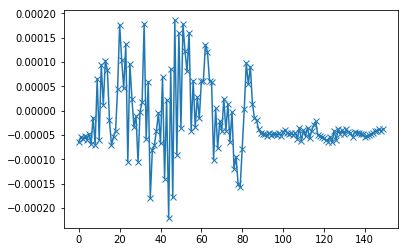

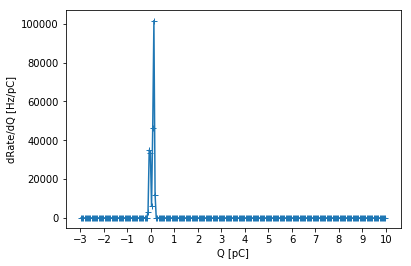

OrderedDict([('Q0', 0.11246338533535216), ('Q1', 5.360059326665534), ('s0', 0.030142352599930887), ('s1', 0.5766400931154485), ('chi2', Power_divergenceResult(statistic=5.921837086183411e+24, pvalue=0.0)), ('norm', 11883.120514220476)]) OrderedDict([('Q0', 6.282762655943781e-09), ('Q1', 0.0), ('s0', 3.392802856041223e-09), ('s1', 0.0)])
{'numEvents': 100000, 'numSamples': 150, 'chMap': array([1, 0]), 'numChan': 1, 'file': '/global/cfs/cdirs/lz/users/heuerman/UmichData/DarkRun/KA0196_DR_1400V_2301121715/KA0196_DR_1400V_2301121715_1'}


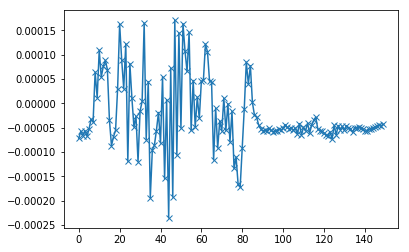

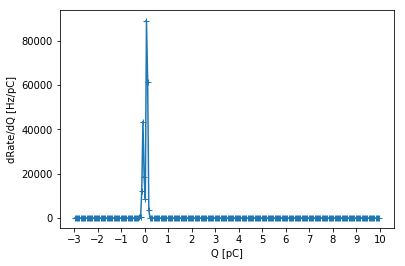

OrderedDict([('Q0', 0.4608868500491603), ('Q1', 0.9260612587740753), ('s0', 0.2668587963676192), ('s1', 0.09870745460208041), ('chi2', Power_divergenceResult(statistic=194.40071656232925, pvalue=2.9097303432165682e-33)), ('norm', 11880.478969459618)]) OrderedDict([('Q0', 4.756941106340102e-06), ('Q1', 0.0), ('s0', 1.4648348756894744e-06), ('s1', 0.0)])
{'numEvents': 100000, 'numSamples': 150, 'chMap': array([1, 0]), 'numChan': 1, 'file': '/global/cfs/cdirs/lz/users/heuerman/UmichData/DarkRun/KA0196_DR_1400V_2301121715/KA0196_DR_1400V_2301121715_2'}


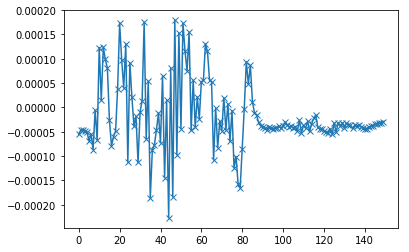

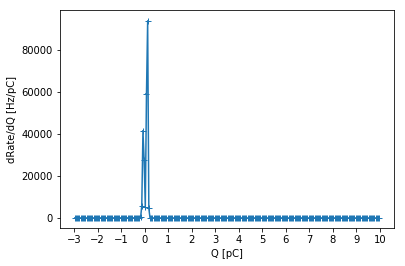

OrderedDict([('Q0', 0.00292789641434007), ('Q1', 5.28839377972369), ('s0', 0.07611692150208407), ('s1', 0.2351959890073385), ('chi2', Power_divergenceResult(statistic=2.532476725557522e+97, pvalue=0.0)), ('norm', 11880.323061076891)]) OrderedDict([('Q0', 1.4204400674027976e-08), ('Q1', 0.0), ('s0', 3.1132886493069294e-09), ('s1', 0.0)])
{'numEvents': 100000, 'numSamples': 150, 'chMap': array([1, 0]), 'numChan': 1, 'file': '/global/cfs/cdirs/lz/users/heuerman/UmichData/DarkRun/KA0196_DR_1400V_2301121715/KA0196_DR_1400V_2301121715_3'}


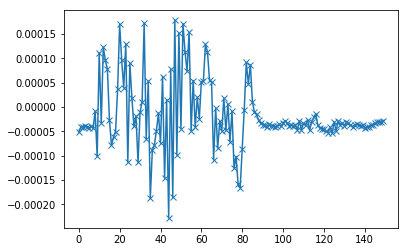

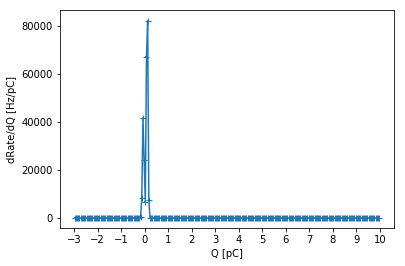

OrderedDict([('Q0', -0.05749288352578787), ('Q1', 5.283648984575728), ('s0', 0.03906030197202471), ('s1', 0.219882168114378), ('chi2', Power_divergenceResult(statistic=8.848785065992532e+248, pvalue=0.0)), ('norm', 11877.700508419988)]) OrderedDict([('Q0', 5.503863573379882e-09), ('Q1', 0.0), ('s0', 2.8993914350457527e-09), ('s1', 0.0)])
{'numEvents': 100000, 'numSamples': 150, 'chMap': array([1, 0]), 'numChan': 1, 'file': '/global/cfs/cdirs/lz/users/heuerman/UmichData/DarkRun/KA0196_DR_1400V_2301121715/KA0196_DR_1400V_2301121715_4'}


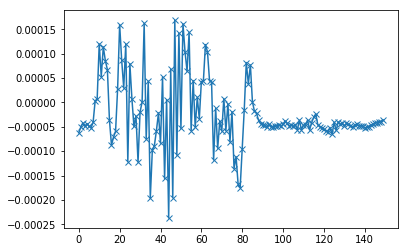

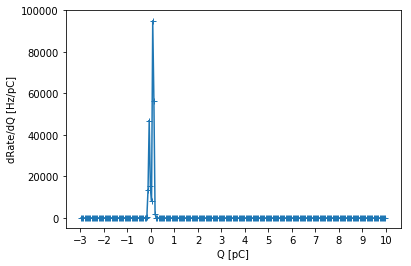

OrderedDict([('Q0', 11.586642264338439), ('Q1', 8.170545416774189), ('s0', 3.8283460416615713), ('s1', 0.34998456616707224), ('chi2', Power_divergenceResult(statistic=94056.66138316666, pvalue=0.0)), ('norm', 11885.06971628952)]) OrderedDict([('Q0', 12.712461431168341), ('Q1', 0.0), ('s0', 1.6863696709287916), ('s1', 0.0)])
{'numEvents': 100000, 'numSamples': 150, 'chMap': array([1, 0]), 'numChan': 1, 'file': '/global/cfs/cdirs/lz/users/heuerman/UmichData/DarkRun/KA0196_DR_1400V_2301121715/KA0196_DR_1400V_2301121715_5'}


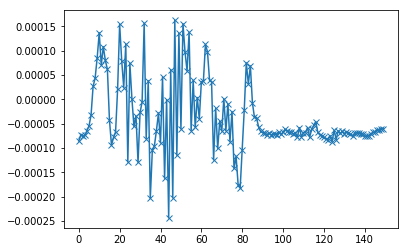

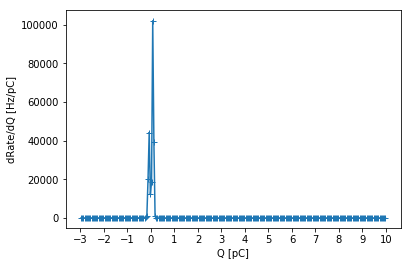

OrderedDict([('Q0', 0.8955597364422657), ('Q1', 4.406558078398377), ('s0', 0.4006238392403078), ('s1', 0.23005982262822716), ('chi2', Power_divergenceResult(statistic=1003.7150704353838, pvalue=1.793751429809157e-203)), ('norm', 11883.78608623582)]) OrderedDict([('Q0', 6.429010713439864e-05), ('Q1', 0.0), ('s0', 1.5374109535699337e-05), ('s1', 0.0)])
{'numEvents': 100000, 'numSamples': 150, 'chMap': array([1, 0]), 'numChan': 1, 'file': '/global/cfs/cdirs/lz/users/heuerman/UmichData/DarkRun/KA0196_DR_1400V_2301121715/KA0196_DR_1400V_2301121715_6'}


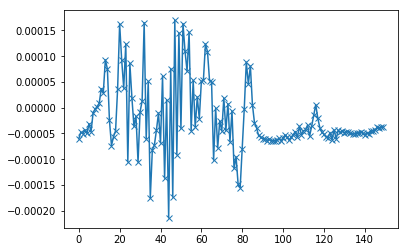

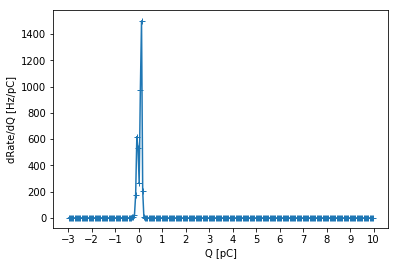

OrderedDict([('Q0', 0.020734344841784862), ('Q1', 1690.3951741888177), ('s0', 0.0856518045822418), ('s1', 2927.959866634458), ('chi2', Power_divergenceResult(statistic=14.013034352104825, pvalue=0.9998686292564696)), ('norm', 215.78277366978512)]) OrderedDict([('Q0', 4.2696202943526516e-08), ('Q1', 1715244135964.5935), ('s0', 1.2375527199187379e-08), ('s1', 1283020112445.5981)])
{'numEvents': 100000, 'numSamples': 150, 'chMap': array([1, 0]), 'numChan': 1, 'file': '/global/cfs/cdirs/lz/users/heuerman/UmichData/DarkRun/KA0196_DR_1400V_2301121715/KA0196_DR_1400V_2301121715_7'}
could not broadcast input array from shape (11197208) into shape (15599998)


TypeError: 'NoneType' object is not subscriptable

<Figure size 432x288 with 0 Axes>

In [5]:
[fullRun(fWave,wDir,True) for fWave in fWaves]